# Federated Learning Implementation with tensorflow



In [1]:
# """
# Adult Dataset Salary Prediction 
# This is part of a study to investigate Differetinal privacy in Machine learning, Naturally we wish to compare it with federated learning.



# Refrences:

# [1] Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018
# [2] Communication-Efficient Learning of Deep Networks from Decentralized Data, H. Brendan McMahan et al, arXiv:1602.05629v3 [cs.LG] 28 Feb 2017

# """

In [2]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import pandas as pd



In [3]:
# file_out = pd.read_csv('adult_processed1.csv')
# cols = []
# for i in list(file_out.columns):
#     if  i != 'income':
#         cols.append(i)
# feature_set1 = pd.read_csv('train1.csv')
# feature_set2 = pd.read_csv('test1.csv')



# x = feature_set1[cols].copy().values
# y = feature_set1[['income']].copy().values
        
# sc = StandardScaler()
# X_train = sc.fit_transform(x)
# y_train = y


# x2 = feature_set2[cols].copy().values
# y2 = feature_set2[['income']].copy().values


# X_test = sc.transform(x2)
# y_test = y2

In [4]:

def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 




In [5]:
import numpy as np
import random
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical 



file_out = pd.read_csv('cmp2.csv')


cols = []
for i in list(file_out.columns):
    if  i != 'two_year_recid':
        cols.append(i)

cols=cols[1:]
print(cols)
feature_set1 = pd.read_csv('cmptrain.csv')
feature_set2 = pd.read_csv('cmptest.csv')
testdata = pd.read_csv('cmptest.csv')

feature_set1=feature_set1.drop(['race'],axis=1)
feature_set2=feature_set2.drop(['race'],axis=1)


x = feature_set1[cols].copy().values
y = feature_set1[['two_year_recid']].copy().values



        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['two_year_recid']].copy().values

X_test = sc.transform(x2)
y_test = y2



# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
X_test.shape, y_test.shape 

['Unnamed: 0', 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'priors_count.1']


((1442, 9), (1442, 1))

In [6]:
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    
    return dataset.shuffle(len(label)).batch(bs)

In [7]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("relu")))
        model.add(Dense(64, Activation("relu")))
        model.add(Dense(32, Activation("relu")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [8]:
lr = 0.01

loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']





In [9]:


x_data=[]
y_data=[]
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    x_data.append(comm_round+1)
    y_data.append(acc)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [10]:
def federated_learning(comms_round,clients_batched,test_batched,global_model):       
    #commence global training loop
    for comm_round in range(comms_round):
                
        # get the global model's weights - will serve as the initial weights for all local models
        global_weights = global_model.get_weights()
        
        #initial list to collect local model weights after scalling
        scaled_local_weight_list = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        
        #loop through each client and create new local model
        for client in client_names:
            smlp_local = SimpleMLP()
            local_model = smlp_local.build(X_train.shape[1],classes=2)
            local_model.compile(loss=loss, 
                        optimizer=optimizer, 
                        metrics=metrics)
            
            #set local model weight to the weight of the global model
            local_model.set_weights(global_weights)
            
            #fit local model with client's data
            local_model.fit(clients_batched[client], epochs=1, verbose=1)
            
            #scale the model weights and add to list
            scaling_factor = weight_scalling_factor(clients_batched, client)
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            scaled_local_weight_list.append(scaled_weights)
            
            #clear session to free memory after each communication round
            K.clear_session()
            
        #to get the average over all the local model, we simply take the sum of the scaled weights
        average_weights = sum_scaled_weights(scaled_local_weight_list)
        
        #update global model 
        global_model.set_weights(average_weights)

    #     test global model and print out metrics after each communications round
        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

    score = global_model.evaluate(X_test, y_test, verbose=0)

    
    return score

In [11]:

#initialize global model





num_client=[2,5,10,15,20]
acc_score=[]
fairness_score=[]
fairness_score1=[]
for num_clients in num_client:
    comms_round = 30
    comms_round=comms_round
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )     
    smlp_global = SimpleMLP()
    global_model = smlp_global.build(X_train.shape[1] ,classes=2)
    global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 

    clients = create_clients(X_train, y_train, num_clients, initial='client')
    print(clients.keys())
    #process and batch the training data for each client
    clients_batched = dict()
    for (client_name, data) in clients.items():
        clients_batched[client_name] = batch_data(data)
        
    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
    test_batched

    temp=federated_learning(comms_round,clients_batched,test_batched,global_model)
    acc_score.append(temp[1])
    from fairlearn.metrics import demographic_parity_ratio,demographic_parity_difference
    
    nn_preds = global_model.predict(X_test)
    nn_preds = (nn_preds > 0.5)

    

    sf_data=testdata['sex']
    fairness_score.append(demographic_parity_ratio(y_test,
                               nn_preds,
                               sensitive_features=sf_data))
    fairness_score1.append(demographic_parity_difference(y_test,
                               nn_preds,
                               sensitive_features=sf_data))



dict_keys(['client_1', 'client_2'])
46/46 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 58.391% | global_loss: 0.6683117151260376
46/46 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 62.552% | global_loss: 0.6522325873374939
46/46 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 64.910% | global_loss: 0.6379255652427673
46/46 [==============================] - 0s 1ms/step
comm_round: 3 | global_acc: 65.742% | global_loss: 0.6265191435813904
46/46 [==============================] - 0s 2ms/step
comm_round: 4 | global_acc: 67.337% | global_loss: 0.6188290119171143
46/46 [==============================] - 0s 1ms/step
comm_round: 5 | global_acc: 67.614% | global_loss: 0.6134543418884277
46/46 [==============================] - 0s 2ms/step
comm_round: 6 | global_acc: 67.822% | global_loss: 0.6099752187728882
46/46 [==============================] - 0s 2ms/step
comm_round: 7 | global_acc: 67.892% | global_loss:

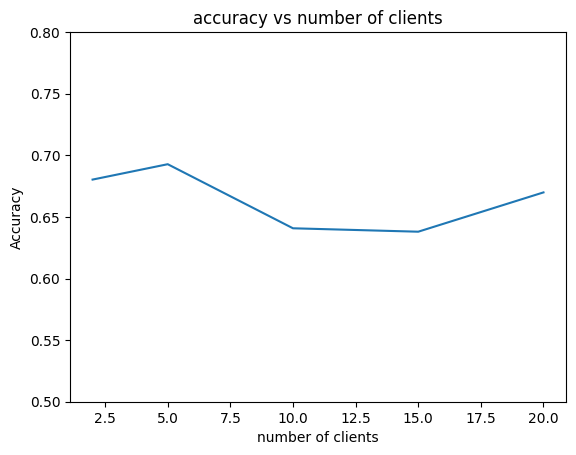

In [23]:
import matplotlib.pyplot as plt
score = global_model.evaluate(X_test, y_test, verbose=0)
score


plt.ylim(0.5,.8)
  
# plotting the points 
plt.plot(num_client, acc_score)
  
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('accuracy vs number of clients')
  
# function to show the plot
plt.show()

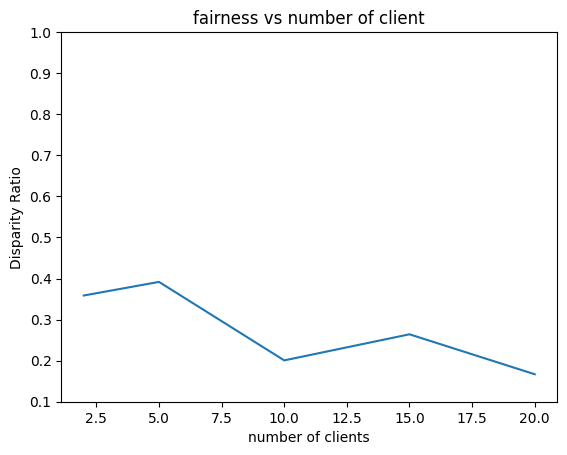

In [28]:
  
# plotting the points 

plt.plot(num_client, fairness_score)
plt.ylim(0.1,1)
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Disparity Ratio')
  
# giving a title to my graph
plt.title('fairness vs number of client')
  
# function to show the plot
plt.show()

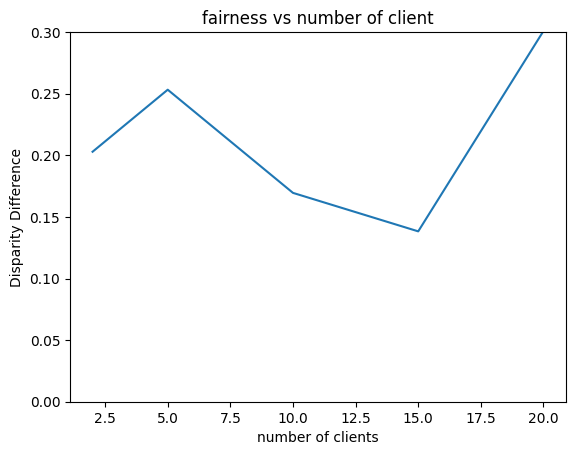

In [14]:
# plotting the points 
plt.ylim(0,0.3)
plt.plot(num_client, fairness_score1)
  
# naming the x axis
plt.xlabel('number of clients')
# naming the y axis
plt.ylabel('Disparity Difference')
  
# giving a title to my graph
plt.title('fairness vs number of client')
  
# function to show the plot
plt.show()

In [15]:
import matplotlib as plt
def eval_performance(results_df):
    summaries = {}
    #accuracy for different sex
    rows = results_df[results_df.sex==0]
    accuracy_for_female = rows.accurate.mean()
    
    rows1 = rows[results_df.pred==1]
    positive_rate_female=rows1.accurate.mean();
    
    summaries['Female_accuracy']=accuracy_for_female
    summaries['Female_Positive_Rate']=positive_rate_female
    

    rows = results_df[results_df.sex==1]
    accuracy_for_male = rows.accurate.mean();
    
    rows1 = rows[results_df.pred==1]
    positive_rate_male=rows1.accurate.mean();

    summaries['Male_accuracy']=accuracy_for_male
    summaries['Male_Positive_Rate']=positive_rate_male



    return summaries


def evaluate_predictor_performance(predictions, x_test, y_test):

    testdata = pd.read_csv('test1.csv')
    testdata['salary'] = y_test
    testdata['pred'] = predictions
    print(testdata)
    testdata['accurate'] = (testdata['pred'] == testdata['salary'])
    sf_data=testdata['sex']
    return eval_performance(testdata)



In [16]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)
print(nn_preds)

# evaluate_predictor_performance(nn_preds, X_test, y_test)




46/46 [==============================] - 0s 2ms/step
[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [False]]


In [17]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(64)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(X_train.shape[1], 2) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=30, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)


metrices={}
nn_preds = SGD_model.predict(X_test)

# approach_2_blind = evaluate_predictor_performance(global_model.predict(X_test, y_test))
# model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

nn_preds = (nn_preds > 0.5)

testdata = pd.read_csv('cmptest.csv')

sf_data=testdata['sex']


from fairlearn.metrics import selection_rate
from fairlearn.metrics import demographic_parity_difference,equalized_odds_difference
print(demographic_parity_difference(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
print(demographic_parity_ratio(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

print(equalized_odds_difference(y_test,
                                nn_preds,
                                sensitive_features=sf_data))







46/46 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 66.990% | global_loss: 0.6518903970718384
46/46 [==============================] - 0s 1ms/step
0.21305331376864756
0.3613905840526326
0.2590969708515908


46/46 [==============================] - 0s 1ms/step
0.3009232086084617
0.6699029126213593
sex
0    0.716312
1    0.658621
Name: accuracy_score, dtype: float64
Precision = 0.676605504587156
Recall = 0.46825396825396826
Accuracy = 0.6699029126213593
f1 = 0.5534709193245778


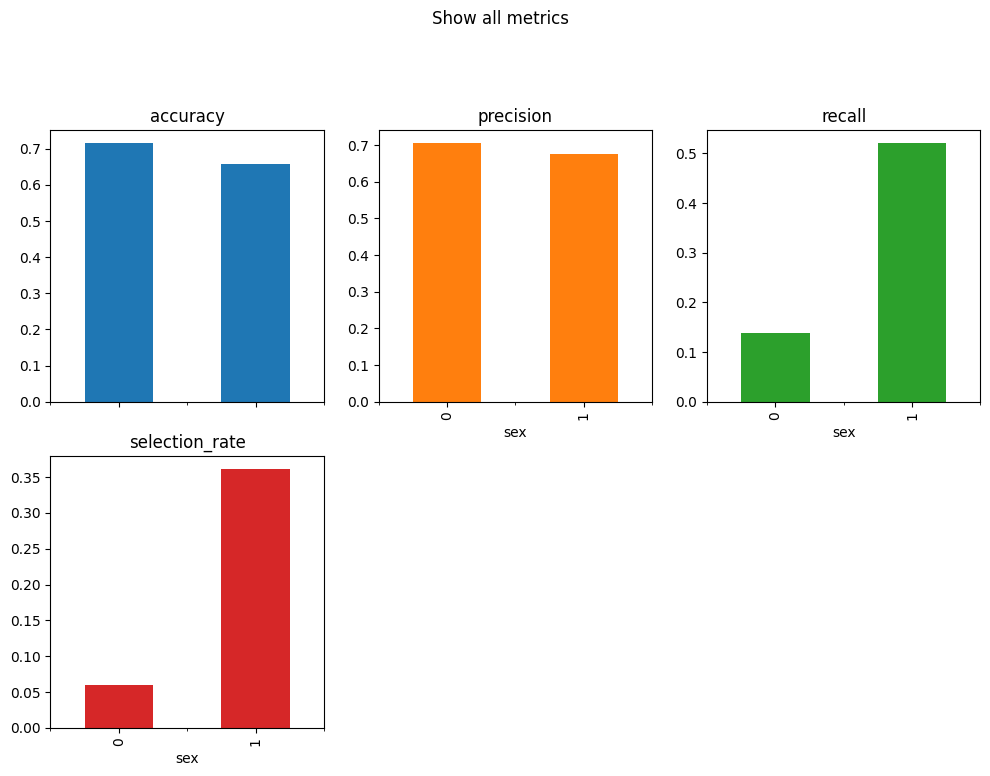

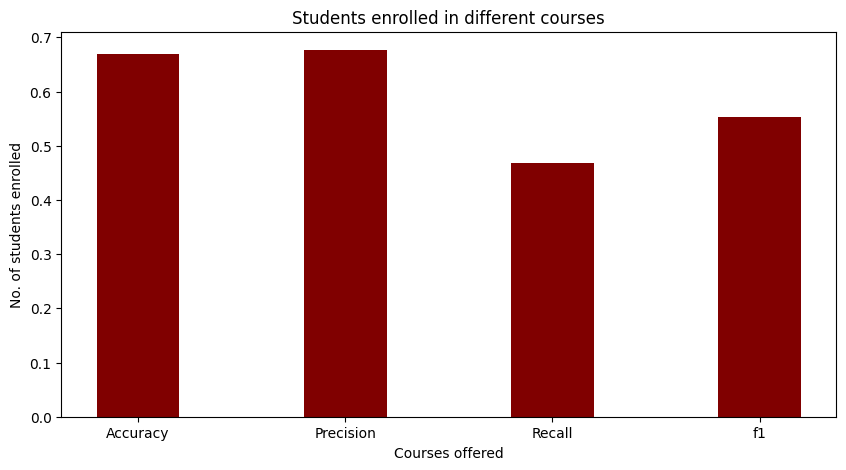

In [18]:
metrices={}
nn_preds = global_model.predict(X_test)

# approach_2_blind = evaluate_predictor_performance(global_model.predict(X_test, y_test))
# model_summary("MLP, equal_datapoints_blind", "", approach_2_blind)

nn_preds = (nn_preds > 0.5)

testdata = pd.read_csv('cmptest.csv')

sf_data=testdata['sex']


from fairlearn.metrics import selection_rate
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_test,
                                    nn_preds,
                                    sensitive_features=sf_data))
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

# print(equalized_odds_difference(y_test,
#                                 nn_preds,
#                                 sensitive_features=sf_data))

gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=nn_preds, sensitive_features=sf_data)
print(gm.overall)
print(gm.by_group)


metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
    
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=nn_preds,
                           sensitive_features=sf_data)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 12],
    title="Show all metrics",
    xlabel='sex',
)











nn_precision =precision_score(y_test, nn_preds)
nn_recall = recall_score(y_test, nn_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_f1 = f1_score(y_test, nn_preds)

metrices['Accuracy']=(nn_accuracy)

metrices['Precision']=nn_precision
metrices['Recall']=nn_recall
metrices['f1']=nn_f1
print("Precision = {}".format(nn_precision))
print("Recall = {}".format(nn_recall))
print("Accuracy = {}".format(nn_accuracy))
print("f1 = {}".format(nn_f1))





c:\Users\sachi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4986130374479889
sex
0    0.404255
1    0.521552
Name: accuracy_score, dtype: float64


array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'recall'}, xlabel='sex'>],
       [<Axes: title={'center': 'selection_rate'}, xlabel='sex'>,
        <Axes: xlabel='sex'>, <Axes: xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

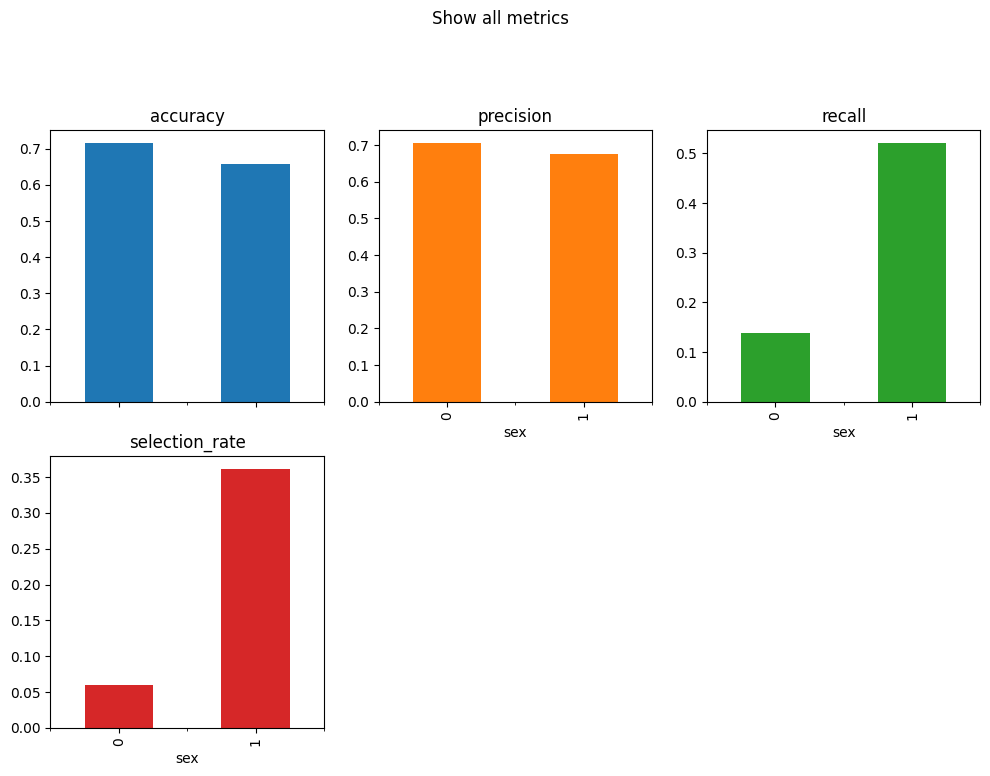

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sf_data)
print(gm.overall)
print(gm.by_group)
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=nn_preds,
                           sensitive_features=sf_data)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 12],
    title="Show all metrics",
)


In [20]:
# def evaluate_predictor_performance(predictions, x_test, y_test):
#     """
#     Returns summary statistics for the predictor's performance
    
#     Input:
#         - predictions: model's predictions on x_test
#         - x_test: test input
#         - y_test: test labels
        
#     Requires:
#         - predictor must have been fitted on x_train and y_train from the same dataset
    
#     Check method evaluate_sex_performance for more on the produced summary statistics
#     """
#     testdata = x_test.copy()
#     testdata['salary'] = y_test
#     testdata['pred'] = pd.Series(predictions, index=x_test.index)
#     testdata['accurate'] = (testdata['pred'] == testdata['salary'])
#     sf_data=testdata['sex']
#     return evaluate_sex_performance(testdata,sf_data)

In [21]:
# arr = nn_preds > 0.5

# unique, counts = np.unique(arr, return_counts=True)

# np.asarray((unique, counts)).T

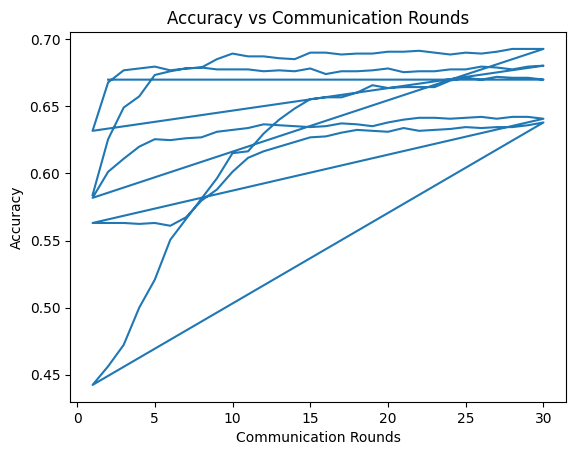

In [22]:
import matplotlib.pyplot as plt
  
  
# plotting the points 
plt.plot(x_data, y_data)
  
# naming the x axis
plt.xlabel('Communication Rounds')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('Accuracy vs Communication Rounds')
  
# function to show the plot
plt.show()